In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import textblob
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import math
from nltk import bigrams,trigrams,ngrams
from collections import Counter
from sklearn.metrics import confusion_matrix
from nltk import everygrams, word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_confusion_matrix


In [6]:
data = pd.read_csv('Reviews.csv')
df = pd.DataFrame(data)
df = df[df['Summary'].apply(lambda x: isinstance(x,str))]

#Adding a new column which is the word count of text column
df['Text_len'] = df['Text'].str.split().str.len()

In [7]:
len(df)

568427

In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_len
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,48
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,31
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,94
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,41
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,27


# EDA

In [6]:
max_text = max(df['Text'].str.split().str.len())
min_text = min(df['Text'].str.split().str.len())
mean_text = sum(df['Text'].str.split().str.len())/len(df)
print('Max number of words in comment: ', max_text, '\n', 
     'Minimum number of words in comment: ', min_text, '\n',
     'Mean number of words in comment: ', mean_text)

Max number of words in comment:  3432 
 Minimum number of words in comment:  3 
 Mean number of words in comment:  80.2664581379843


<AxesSubplot:>

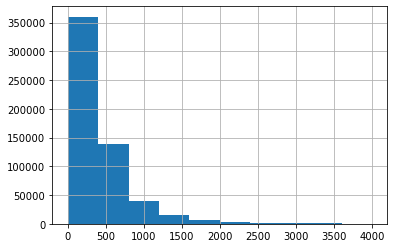

In [7]:
#Comment length analysis on character level
df['Text'].str.len().hist(range = [0,4000])

<AxesSubplot:>

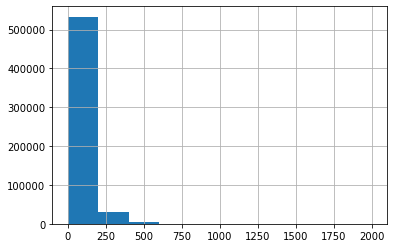

In [8]:
#Comment length analysis on word level
df['Text'].str.split().map(lambda x: len(x)).hist(range = [0,2000])

<AxesSubplot:>

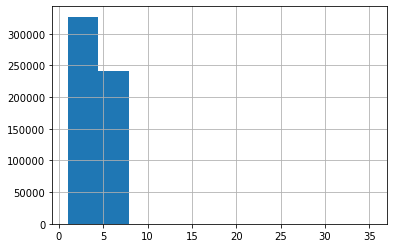

In [9]:
#Comment average word length
df['Text'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

# Data Pre-Processing

<BarContainer object of 10 artists>

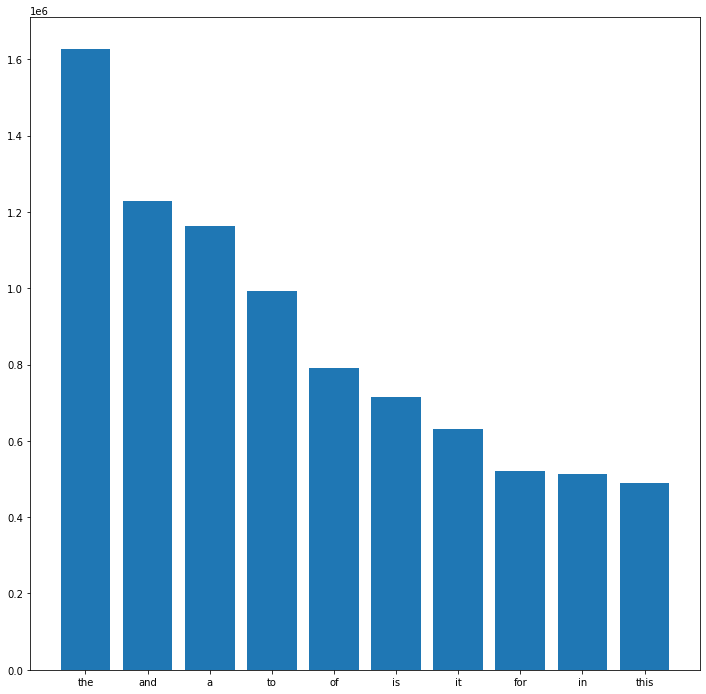

In [9]:
#Use values.tolist() to add all the text list into a single list
#Then use two for loops in a list to store all the words in a single list
#Then count all the unique stop words
stop = set(stopwords.words('english'))
text = df['Text'].str.split().values.tolist()
corpus = [word for i in text for word in i]
corpus_dict = defaultdict(int)
for word in corpus:
    if word in stop:
        corpus_dict[word] += 1
        
#Reverse sort the corpus dict by the stop word counts
#Since there are 162 stop words in the dict, we just plot the top 10 of them 
corpus_dict = dict(sorted(corpus_dict.items(), key = lambda item: item[1], reverse= True))
unique_stopwords = corpus_dict.keys()
stopwords_count = corpus_dict.values()
plt.figure(figsize=(12,12))
plt.bar(range(10),list(stopwords_count)[:10], tick_label = list(unique_stopwords)[:10],)

In [10]:
#Tokenize words in Summary
lemm = WordNetLemmatizer()
df['Summary_word_ls'] = df['Summary'].str.split()
df['Summary_no_stopwords'] = df['Summary_word_ls'].apply(lambda x : [re.sub(r'[.,"\'-?:!;]', '', i) for i in x])
df['Summary_no_stopwords'] = df['Summary_no_stopwords'].apply(lambda x : [re.sub(r'\<a href', ' ', i) for i in x])
df['Summary_no_stopwords'] = df['Summary_no_stopwords'].apply(lambda x : [re.sub(r'&amp;', '', i) for i in x])
df['Summary_no_stopwords'] = df['Summary_no_stopwords'].apply(lambda x : [re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', i) for i in x])
df['Summary_no_stopwords'] = df['Summary_no_stopwords'].apply(lambda x : [re.sub(r'<br />', ' ', i) for i in x])
df['Summary_no_stopwords'] = df['Summary_no_stopwords'].apply(lambda x : [re.sub(r'\'', ' ', i) for i in x])
df['Summary_no_stopwords'] = df['Summary_no_stopwords'].apply(lambda x : [i for i in x if i not in stop])
df['Summary_no_stopwords'] = df['Summary_no_stopwords'].apply(lambda x: [item.lower() for item in x])
df['Summary_no_stopwords'] = [' '.join(map(str,l)) for l in df.Summary_no_stopwords]
def lemmatize_text(text):
    return [lemm.lemmatize(word) for word in nltk.WordPunctTokenizer().tokenize(text)]
df['Summary_cleaned'] = df.Summary_no_stopwords.apply(lemmatize_text)

In [ ]:
# #Tokenize words in Text
# lemm = WordNetLemmatizer()
# df['Text_word_ls'] = df['Text'].str.split()
# df['Text_no_stopwords'] = df['Text_word_ls'].apply(lambda x : [re.sub(r'[.,"\'-?:!;]', '', i) for i in x])
# df['Text_no_stopwords'] = df['Text_no_stopwords'].apply(lambda x : [re.sub(r'\<a href', ' ', i) for i in x])
# df['Text_no_stopwords'] = df['Text_no_stopwords'].apply(lambda x : [re.sub(r'&amp;', '', i) for i in x])
# df['Text_no_stopwords'] = df['Text_no_stopwords'].apply(lambda x : [re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', i) for i in x])
# df['Text_no_stopwords'] = df['Text_no_stopwords'].apply(lambda x : [re.sub(r'<br />', ' ', i) for i in x])
# df['Text_no_stopwords'] = df['Text_no_stopwords'].apply(lambda x : [re.sub(r'\'', ' ', i) for i in x])
# df['Text_no_stopwords'] = df['Text_no_stopwords'].apply(lambda x : [i for i in x if i not in stop])
# df['Text_no_stopwords'] = df['Text_no_stopwords'].apply(lambda x: [item.lower() for item in x])
# df['Text_no_stopwords'] = [' '.join(map(str,l)) for l in df.Text_no_stopwords]
# def lemmatize_text(text):
#     return [lemm.lemmatize(word) for word in nltk.WordPunctTokenizer().tokenize(text)]
# df['Text_cleaned'] = df.Text_no_stopwords.apply(lemmatize_text)


# Word Cloud Analysis

#### Insight from the word cloud: 
#### Since we used 3 as threshold to separate the comment to positive and negative, there is still 
#### a chance that people who rate 3 also satisfied with the products and provided good review.
#### Thus, if we only mark the review by two groups, some good words like pretty good would appear
#### in negative word cloud which doesn't make sense. However, if we separate using positive, neutral, 
#### and negative, more of the good words in negative word cloud will move to the neutral word cloud.
#### __Please see the two cells of code for detail__

positive size:  443777 
 neutal size:  42638 
 negative size:  82012


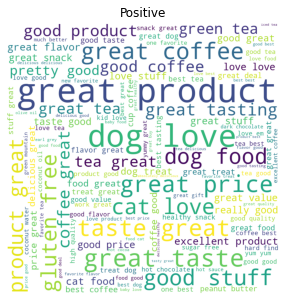

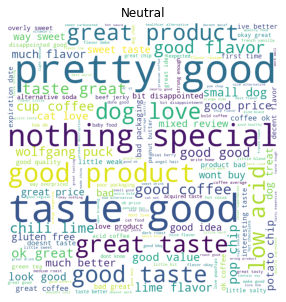

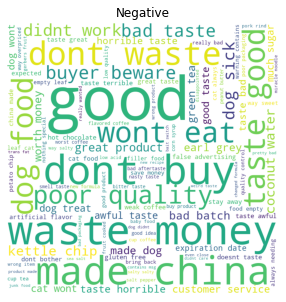

In [12]:
#Word cloud with positive, neutral, and negative
def categorize_sentiment(row):
    if row['Score'] > 3:
        return 'Positive'
    elif row['Score'] == 3:
        return 'Neutral'
    else:
        return 'Negative'
df['Sentiment'] = df.apply(lambda row : categorize_sentiment(row), axis = 1)


def wc(df, sentiment):
    df= df[df['Sentiment'] == sentiment]
    wc = ''
    for i in range(len(df)):
        if i not in df.Id:
            continue
        for word in df['Summary_cleaned'][i]:
            wc += ''.join(word)+' '

    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',min_font_size = 10,
                         collocation_threshold = 2).generate(wc)
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(sentiment)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    
# Word cloud with only positive review
wc(df,'Positive')

# Word cloud with only positive review
wc(df,'Neutral')

# Word cloud with only negative review
wc(df,'Negative')


#check if the three categories have balanced data
positive_len = len(df[df['Sentiment'] == 'Positive'])
negative_len = len(df[df['Sentiment'] == 'Negative'])
neutral_len = len(df[df['Sentiment'] == 'Neutral'])
print('positive size: ', positive_len, '\n', 'neutal size: ', neutral_len, '\n', 'negative size: ', negative_len)

positive size:  443777 
 neutal size:  0 
 negative size:  124650


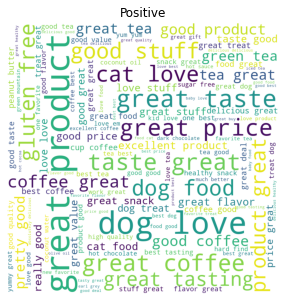

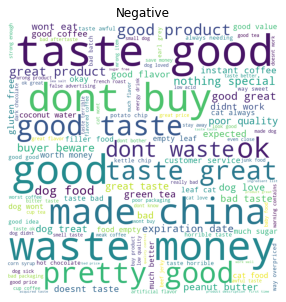

In [11]:
# word cloud with only positive and negative
#Define sentiment based on the given score
def categorize_sentiment(row):
    if row['Score'] > 3:
        return 'Positive'
    else:
        return 'Negative'
df['Sentiment'] = df.apply(lambda row : categorize_sentiment(row), axis = 1)

def wc(df, sentiment):
    df= df[df['Sentiment'] == sentiment]
    wc = ''
    for i in range(len(df)):
        if i not in df.Id:
            continue
        for word in df['Summary_cleaned'][i]:
            wc += ''.join(word)+' '

    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',min_font_size = 10,
                         collocation_threshold = 2).generate(wc)
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(sentiment)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    
# Word cloud with only positive review
wc(df,'Positive')

# Word cloud with only negative review
wc(df,'Negative')

#check if the three categories have balanced data
positive_len = len(df[df['Sentiment'] == 'Positive'])
negative_len = len(df[df['Sentiment'] == 'Negative'])
neutral_len = len(df[df['Sentiment'] == 'Neutral'])
print('positive size: ', positive_len, '\n', 'neutal size: ', neutral_len, '\n', 'negative size: ', negative_len)

# Bag of Word (BOW uni-gram default)

In [13]:
# The toarray() function can't take 38260 features, so here only has 10000 rows for displaying purposes.
bow = CountVectorizer(max_features=10000)
bow_input = np.array([','.join(map(str,l)) for l in df['Summary_cleaned'][:10000]])
bow_fit = bow.fit_transform(bow_input)
bow_array = bow_fit.toarray()
pd.DataFrame(data = bow_array, columns = bow.get_feature_names())

,able,about,above,absolute,absolutel,absolutely,absotively,acaigrape,acceptable,accident,...,yumo,yumyum,zany,zero,zesty,zing,zippy,ziwipeak,zots,zukes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# BOW of summary data
def bow(text):
    bow = CountVectorizer()
    bow_input = np.array([' '.join(map(str,l)) for l in df[text]])
    bow_fit = bow.fit_transform(bow_input)
    feature_array = np.array(bow.get_feature_names())
    print(feature_array)
    print('Length of feature is: ',len(feature_array))
    
bow('Summary_cleaned')

['aa' 'aaa' 'aaaa' ... 'zzzzzzzzz' 'zzzzzzzzzzz' 'åwesome']
Length of feature is:  38260


C:\Users\shuny\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Bag of n-Grams

In [17]:
def n_gram(gram_num, column_name):
    converter = CountVectorizer(ngram_range=[gram_num, gram_num]) 
    summary_bow_input = np.array([' '.join(map(str,l)) for l in df[column_name]])
    bow_fit = converter.fit_transform(summary_bow_input)
    feature_names = converter.get_feature_names()
    print('Feature length for ', gram_num, ' is: ', len(feature_names))

n_gram(2, 'Summary_cleaned')
n_gram(3, 'Summary_cleaned')

Feature length for  2  is:  302546
Feature length for  3  is:  371914


# General n-gram function

In [17]:
#Function to generate Ngrams 
def generate_N_grams(text,ngram):
  temp=zip(*[text[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

def run_ngram(training_set, gram_num):
    #Add positive word and negative word count into their own dictionary respectivly
    positive_dict = defaultdict(int)
    negative_dict = defaultdict(int)

    for text in training_set[training_set.Sentiment == 'Positive'].Summary_cleaned:
        for word in generate_N_grams(text,gram_num):
            positive_dict[word] += 1

    for text in training_set[training_set.Sentiment == 'Negative'].Summary_cleaned:
        for word in generate_N_grams(text,gram_num):
            negative_dict[word] += 1

    #Turn the two dictionary into dataframe and find the most frequent words
    df_positive = pd.DataFrame(sorted(positive_dict.items(), key = lambda x : x[1], reverse= True))
    df_negative = pd.DataFrame(sorted(negative_dict.items(), key = lambda x : x[1], reverse= True))

    
    #Bar plot for top ten positive words
    plt.figure(figsize=(6,2))
    plt.subplots_adjust(top = 6, bottom=3,left = 5, right = 8)
    plt.subplot(1,2,1)
    plt.bar(df_positive[0][:10], df_positive[1][:10], color = 'green', width = 0.3)
    if gram_num > 1:
        plt.xticks(rotation = 45)
    plt.ylabel("Count")
    plt.title("Top 10 positive")
    
    
    #Bar plot for top ten positive words
    plt.subplot(1,2,2)
    plt.bar(df_negative[0][:10], df_negative[1][:10], color = 'red', width = 0.3)
    if gram_num > 1:
        plt.xticks(rotation = 45)
    plt.ylabel("Count")
    plt.title("Top 10 negative")
    
    
    

# Unigrams

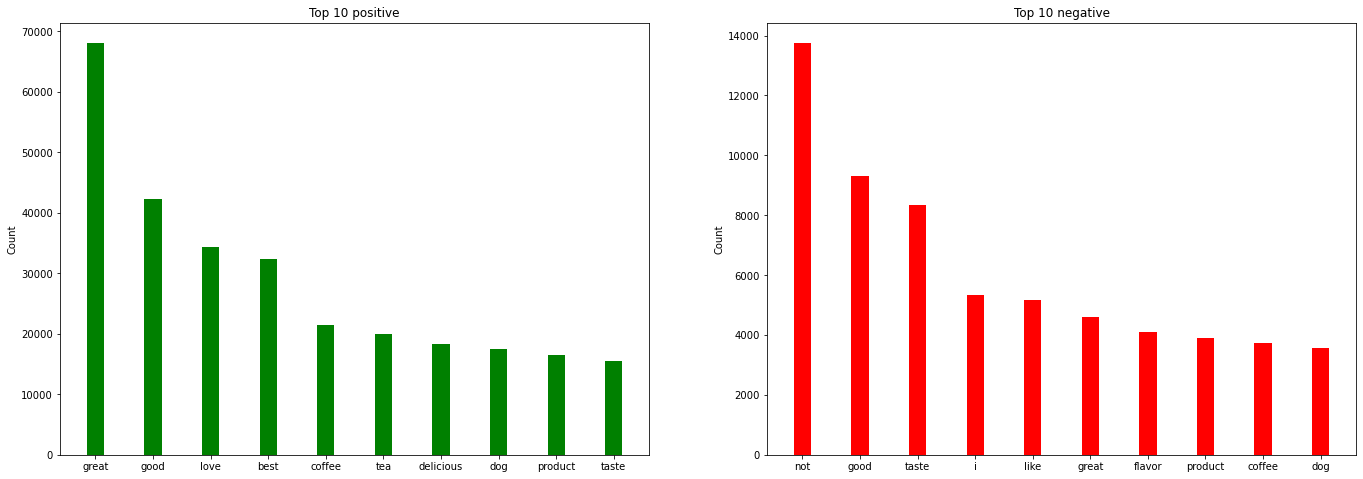

In [18]:
run_ngram(df, 1)

# Bigrams

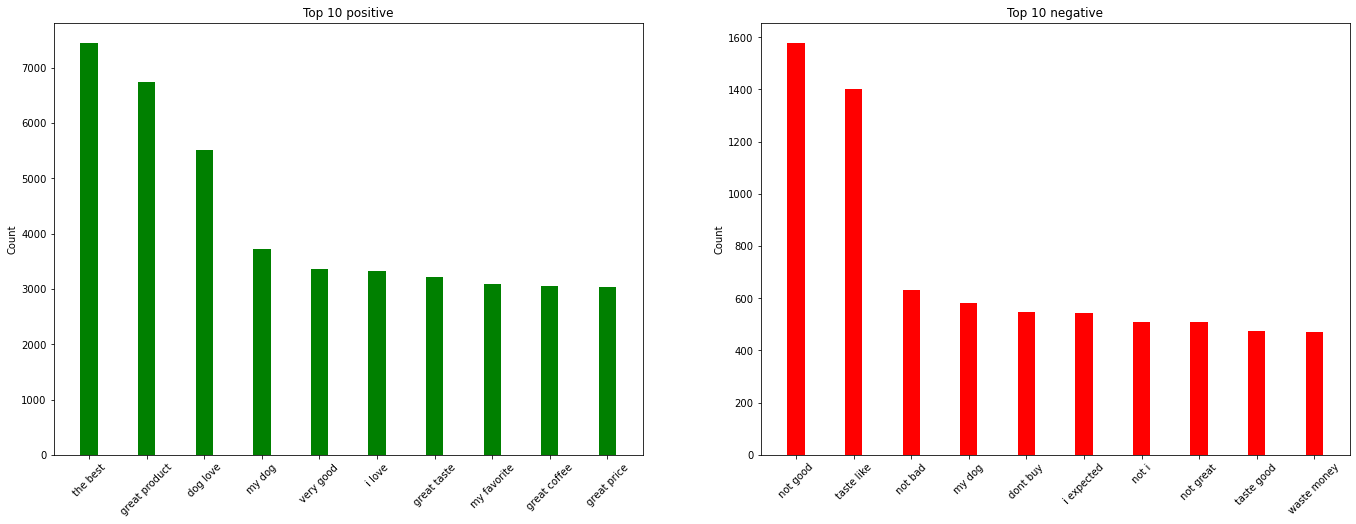

In [19]:
run_ngram(df,2)

# Trigrams

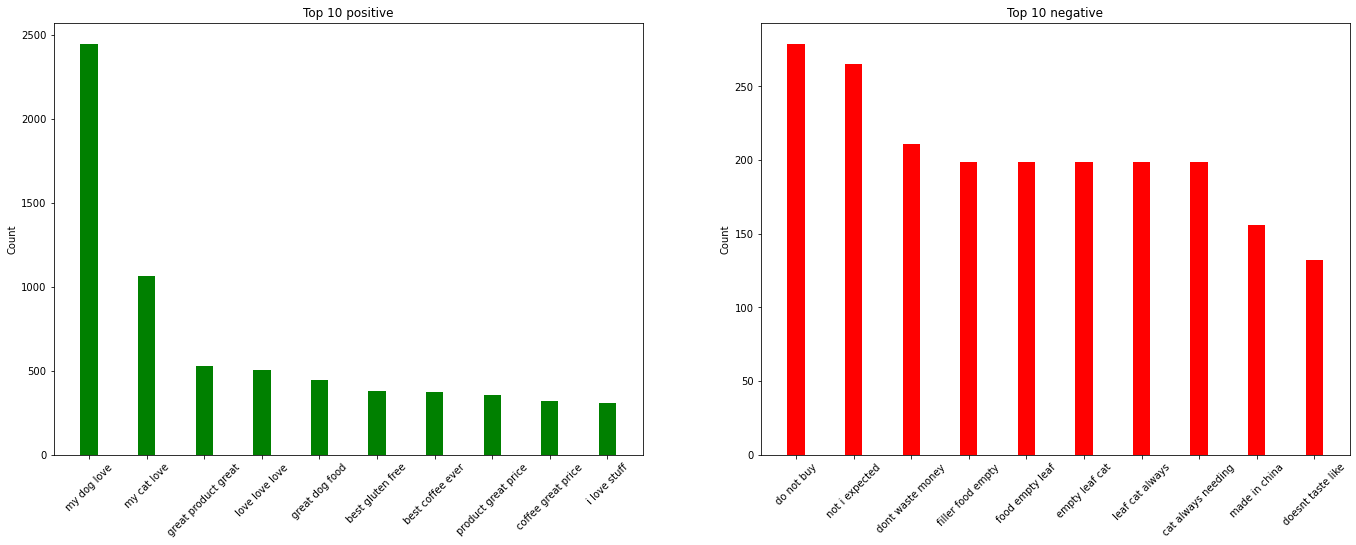

In [20]:
run_ngram(df,3)

# TFIDF（手写）有点问题，需要调整

In [21]:
N = len(df)
def IDF(word_ls, dataframe):
    idf_ls = []
    for i in range(len(word_ls)):
        count = 0
        cur_word = tfidf_df['word'][i]
        for text in dataframe.Summary_no_stopwords:
            for word in text:
                if word == cur_word:
                    count += 1
                    break
        idf_ls.append(math.log(N/count))
    return idf_ls
                
tfidf_corpus_dict = defaultdict(int)
for text in df.Summary_no_stopwords:
    for word in text:
        tfidf_corpus_dict[word] += 1
        
key_col = pd.DataFrame(tfidf_corpus_dict.keys(),columns=['word'])
count_col = pd.DataFrame(tfidf_corpus_dict.values(),columns=['count'])
key_col.reset_index(drop = True, inplace = True)
count_col.reset_index(drop = True, inplace = True)
tfidf_df = pd.concat([key_col, count_col],axis = 1)
tfidf_df['TF'] = tfidf_df['count']/(tfidf_df['count'].sum())
tfidf_df['IDF'] = pd.DataFrame(IDF(tfidf_df,df))
tfidf_df['TFIDF'] = tfidf_df['TF'] * tfidf_df['IDF']
tfidf_df.sort_values(by=['TFIDF'],ascending=False)

,word,count,TF,IDF,TFIDF
7,l,479384,4.380114e-02,0.647008,0.028340
12,n,463492,4.234910e-02,0.663762,0.028110
8,i,583113,5.327882e-02,0.517941,0.027595
11,f,238031,2.174881e-02,1.231669,0.026787
18,c,406559,3.714715e-02,0.702801,0.026107
22,p,236547,2.161321e-02,1.195326,0.025835
19,m,234545,2.143029e-02,1.196891,0.025650
2,d,375530,3.431204e-02,0.743174,0.025500
15,r,618037,5.646982e-02,0.445016,0.025130
17,h,237228,2.167544e-02,1.158312,0.025107


# TFIDF(调包)

In [22]:
tfidf = TfidfVectorizer()
df['Summary_new'] = [' '.join(map(str,l)) for l in df.Summary_cleaned]
transformed = tfidf.fit_transform(pd.Series(df.Summary_new))

tfidf_test_df = pd.DataFrame(transformed[0].T.todense(),index=tfidf.get_feature_names(), columns=["TF-IDF"])
tfidf_test_df = tfidf_test_df.sort_values('TF-IDF', ascending=False)

tfidf_test_df

,TF-IDF
quality,0.612495
food,0.515015
dog,0.469332
good,0.373279
podkups,0.000000
...,...
foreverish,0.000000
forewarning,0.000000
forged,0.000000
forgeddaboutit,0.000000


# Data Split

In [23]:
df['Sentiment'] = df['Sentiment'].astype('category').cat.codes
cv= CountVectorizer(ngram_range=(1,3), binary =True, stop_words = 'english')
X = pd.DataFrame(df['Score']).join(pd.DataFrame(df['Summary_cleaned']))
y = df['Sentiment']
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3)

cv = CountVectorizer(ngram_range=[2,2])
tfidf = TfidfVectorizer()

bow_X_train = cv.fit_transform(np.array([' '.join(map(str,l)) for l in X_train['Summary_cleaned']]))
bow_X_test = cv.transform(np.array([' '.join(map(str,l)) for l in X_test['Summary_cleaned']]))

tfidf_X_train = tfidf.fit_transform(np.array([' '.join(map(str,l)) for l in X_train['Summary_cleaned']]))
tfidf_X_test = tfidf.transform(np.array([' '.join(map(str,l)) for l in X_test['Summary_cleaned']]))

# ML function, AUC ROC plot, precision vs recall plot

In [24]:
def ML_function(X_train, y_train, model_name, parameter):
    if model_name == LogisticRegression:
        model = model_name(max_iter = 999, C = 1.0)
        model = GridSearchCV(model, parameter, scoring = 'roc_auc', cv = 5)
        model = model.fit(X_train, y_train)
        return model
    elif model_name == DecisionTreeClassifier or model_name == RandomForestClassifier:
        model = model_name()
        model = GridSearchCV(model, param_grid, scoring = "roc_auc", cv = 5).fit(X_train,y_train)
        return model

def AUC_ROC(model, X_test, y_test):
    yhat = model.predict_proba(X_test)
    yhat = yhat[:,1]
    fpr,tpr,threshold = roc_curve(y_test,yhat)
    plt.plot([0,1],[0,1],linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    print('The ROC AUC score is: ', roc_auc_score(y_test,yhat))

def plot_prec_reca(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color = 'blue')
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    
def conclusion(model, X_test,y_test):
    print('The best parameter combiantion is: ', model.best_params_)
    print('Confusion Matix: ', '\n', confusion_matrix(y_test, model.predict(X_test)))
    print('Score of model is : ', model.score(X_test,y_test))
    
def F1_cal(model, X_test, yest):
    cnf_matrix = confusion_matrix(y_test, bow_LR.predict(bow_X_test))
    FP = cnf_matrix[0][1]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[0][0]
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    print('The F1 score is: ', 2*Precision*Recall/(Precision+Recall))

# Logistic Regression

The ROC AUC score is:  0.8996183683025876
The best parameter combiantion is:  {'solver': 'newton-cg'}
Confusion Matix:  
 [[ 18108  19390]
 [  1960 131071]]
Score with BOW features:  0.8996183681021224
Score with TFIDF features:  0.8996183681021224
The F1 score is:  0.6291213563561825


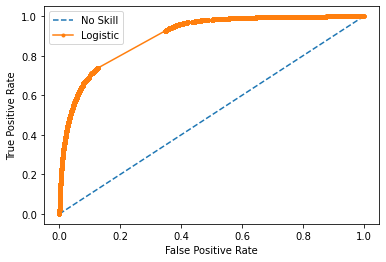

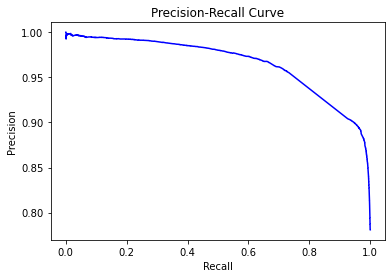

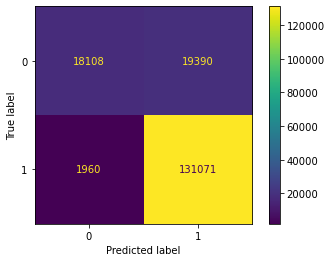

In [25]:
#Bag of tri-grams feature
param_grid = {
    'solver'  : ['newton-cg', 'lbfgs']
}
bow_LR = ML_function(bow_X_train,y_train,LogisticRegression, param_grid)
AUC_ROC(bow_LR, bow_X_test, y_test)
plot_prec_reca(bow_LR, bow_X_test, y_test)
conclusion(bow_LR, bow_X_test,y_test)
F1_cal(bow_LR, bow_X_test,y_test)
plot_confusion_matrix(bow_LR, bow_X_test, y_test)


The ROC AUC score is:  0.9219888792246788
The best parameter combiantion is:  {'solver': 'newton-cg'}
Confusion Matix:  
 [[ 23153  14345]
 [  4651 128380]]
Score with BOW features:  0.9219888757165375
Score with TFIDF features:  0.9219888757165375
The F1 score is:  0.6291213563561825


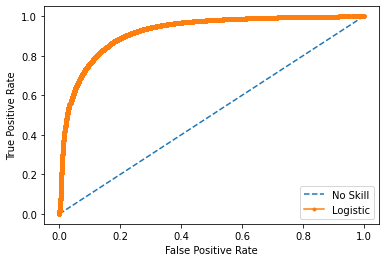

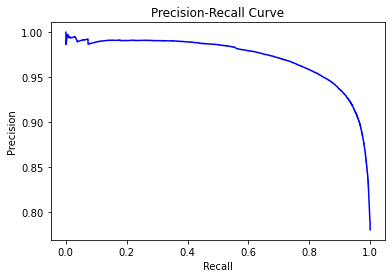

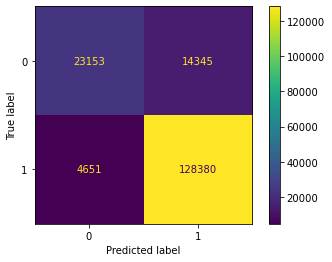

In [26]:
#tfidf feature
param_grid = {
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}
tfidf_LR = ML_function(tfidf_X_train,y_train,LogisticRegression, param_grid)
AUC_ROC(tfidf_LR, tfidf_X_test, y_test)
plot_prec_reca(tfidf_LR, tfidf_X_test, y_test)
conclusion(tfidf_LR, tfidf_X_test,y_test)
F1_cal(bow_LR, tfidf_X_test,y_test)
plot_confusion_matrix(tfidf_LR, tfidf_X_test, y_test)

# Decision Tree

In [ ]:
param_grid = {
    #'criterion':['gini','entropy'],
    'max_depth' :[1,2,3,4,5,6],
    'min_samples_split':[2,3,4],
    'min_samples_leaf': [1,2,3]
}

bow_decision_tree = ML_function(bow_X_train, y_train, DecisionTreeClassifier, param_grid)
AUC_ROC(bow_decision_tree, bow_X_test, y_test)
plot_prec_reca(bow_decision_tree, bow_X_test, y_test)
conclusion(bow_decision_tree, bow_X_test,y_test)
F1_cal(bow_decision_tree, bow_X_test,y_test)
plot_confusion_matrix(bow_decision_tree, bow_X_test, y_test)


In [ ]:
#tfidf feature
param_grid = {
    #'criterion':['gini','entropy'],
    'max_depth' :[1,2,3,4,5,6],
    'min_samples_split':[2,3,4],
    'min_samples_leaf': [1,2,3]
}

tfidf_decision_tree = ML_function(tfidf_X_train,y_train,DecisionTreeClassifier, param_grid)
AUC_ROC(tfidf_decision_tree, tfidf_X_test, y_test)
plot_prec_reca(tfidf_decision_tree, tfidf_X_test, y_test)
F1_cal(tfidf_decision_tree, tfidf_X_test,y_test)
conclusion(tfidf_decision_tree, tfidf_X_test,y_test)
plot_confusion_matrix(tfidf_decision_tree, tfidf_X_test, y_test)

# Random Forest Classifier

The ROC AUC score is:  0.6169011828369844
The best parameter combiantion is:  {'max_depth': 5}
Confusion Matix:  
 [[     0  37563]
 [     0 132966]]
Score with BOW features:  0.6169011828369844
Score with TFIDF features:  0.6169011828369844
The F1 score is:  0.6279408702894025


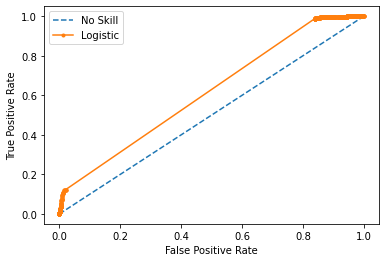

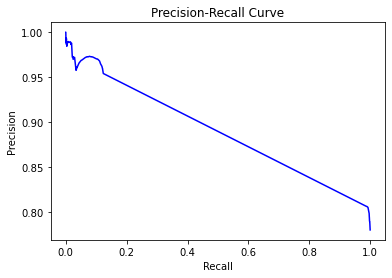

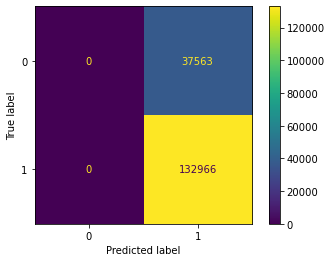

In [61]:
param_grid = {
    #'bootstrap': 'True',
    #'criterion': ['gini','entropy'],
    'max_depth': [1,2,3,4,5],
    #'max_features': ['auto','sqrt','log2'],
    #'min_sample_split' : [2,3],
    #'min_sample_leaf' : [1,2],
    #'n_estimators': [50,100,200]
}

bow_rfc = ML_function(bow_X_train, y_train,RandomForestClassifier, param_grid)
AUC_ROC(bow_rfc, bow_X_test, y_test)
plot_prec_reca(bow_rfc, bow_X_test, y_test)
conclusion(bow_rfc, bow_X_test,y_test)
F1_cal(bow_rfc, bow_X_test,y_test)
plot_confusion_matrix(bow_rfc, bow_X_test, y_test)

The ROC AUC score is:  0.9523060400463257
The F1 score is:  0.6279408702894025
The best parameter combiantion is:  {'max_depth': None}
Confusion Matix:  
 [[ 28419   9144]
 [  4405 128561]]
Score with BOW features:  0.9523060400463257
Score with TFIDF features:  0.9523060400463257


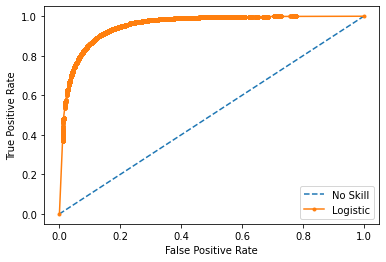

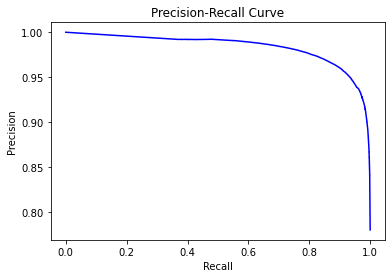

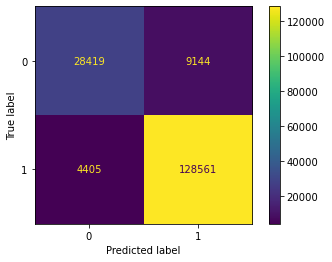

In [64]:
param_grid = {
    #'bootstrap': 'True',
    #'criterion': ['gini','entropy'],
    'max_depth': [1,2,3,4,5,None],
    #'max_features': ['auto','sqrt','log2'],
    #'min_sample_split' : [2,3],
    #'min_sample_leaf' : [1,2],
    #'n_estimators': [50,100,200]
}

tfidc_rfc = ML_function(tfidf_X_train,y_train,RandomForestClassifier, param_grid)
AUC_ROC(tfidc_rfc, tfidf_X_test, y_test)
plot_prec_reca(tfidc_rfc, tfidf_X_test, y_test)
F1_cal(tfidc_rfc, tfidf_X_test,y_test)
conclusion(tfidc_rfc, tfidf_X_test,y_test)
plot_confusion_matrix(tfidc_rfc, tfidf_X_test, y_test)

## Feature Importance Analysis
#### Knowing that BOW and TFIDF feature perform similarly for logsitic regression;
#### TFIDF perform the best for Decision Tree Classifier and Random Forest Classifier
 

In [139]:
#Initialize the freature names to a dictionary so that we can fetch them easily
feature_names = cv.fit(np.array([' '.join(map(str,l)) for l in X_train['Summary_cleaned']]))
feature_names_dict = feature_names.vocabulary_

def topNfeature(N, gridSearch_model):
    importance = sorted(enumerate(gridSearch_model.best_estimator_.coef_[0]), key = lambda x:x[1], reverse=True)
    topN_feature_list = [] 
    for index, importance in importance[:N]:
        feature_name = list(feature_names_dict.items())[index][0]
        topN_feature_list.append(feature_name)      
    return topN_feature_list
#        print('Feature: %s' % feature_name)
        #print('Feature: %s, Score: %.5f' % (feature_name,importance))
        

In [140]:
top10_bow_LR = topNfeature(10, bow_LR)   
top10_tfidf_LR = topNfeature(10, tfidf_LR)
top10_tfidf_decision_tree = topNfeature(10, tfidf_decision_tree)
top10_tfidf_random_forest = topNfeature(10, tfidc_rfc)

NameError: name 'tfidf_decision_tree' is not defined